# Topic Classification

For the baseline model, this is working from the code used in assignment 3.  As it performed well, although I make use something else.  Given that the labels are known and theres only 2 options, this could be implemented with several models.

In [27]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\evaluation.csv
data\Maize Seedling.jpeg
data\pic2textJPG.JPG
data\test.csv
data\train.csv


In [2]:
input_data_path = 'data/'
training_data_file = 'train.csv'
df = pd.read_csv(input_data_path + training_data_file)
df.head()

,id,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization�s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [3]:
real=df[df['label']==1]
fake=df[df['label']==0]

In [8]:
# split data into train and validation sets: df_train and df_val
from sklearn.model_selection import train_test_split


X = df['text_shorten'].copy()


y = df['label'].copy()


X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train_raw)

6538     WASHINGTON (Reuters) - The son of U.S. Preside...
11573    Trump was right again! There will be NO CHARGE...
4058     SEOUL (Reuters) - President Donald Trump will ...
9159     republican presidential nominee donald trump h...
22242    WASHINGTON (Reuters) - Senate Republicans woul...
                               ...                        
21575     I thought it would be easier to carry just on...
5390     WASHINGTON (Reuters) - A Republican plan backe...
860      KANDAHAR, Afghanistan (Reuters) - A roadside b...
15795    WASHINGTON (Reuters) - The Republican-controll...
23654    Trump handles this in a great way! Pretty funny! 
Name: text_shorten, Length: 19470, dtype: object


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
#import seaborn as sns
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()
# an alternative is to use term frequency:
#from sklearn.feature_extraction.text import CountVectorizer
#one_hot_vectorizer = CountVectorizer(binary=True)
#X_train = one_hot_vectorizer.fit_transform(X_train_raw))

print(f"X_train.shape = {X_train.shape}")
print(X_train)

print(f"Number of samples: {X_train.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
#print(f"Number of catagories: {X_train.shape[2]}")

X_train.shape = (19470, 57206)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of samples: 19470
Number of features: 57206


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

confusion_matrix = metrics.confusion_matrix(X_train, predictions_train)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=['True', 'Fake'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on X_train): 0.9982


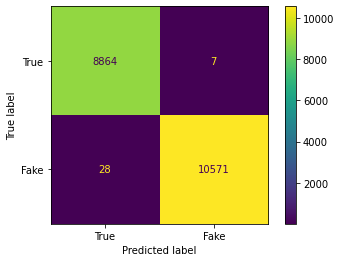

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets

model = HistGradientBoostingClassifier(loss='log_loss', learning_rate=.2,max_iter=42, max_bins=5,max_leaf_nodes=64,max_depth=48,min_samples_leaf=16).fit(X_train, y_train)
# model = model.fit()

predictions_train = model.predict(X_train)

disp = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train), display_labels=['True', 'Fake'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

In [11]:
X_val = tfidf_vectorizer.transform(X_val_raw).toarray()
print(f"X_val.shape = {X_val.shape}")
type(X_val)

X_val.shape = (4868, 57206)


numpy.ndarray

accuracy (on X_train): 0.9832


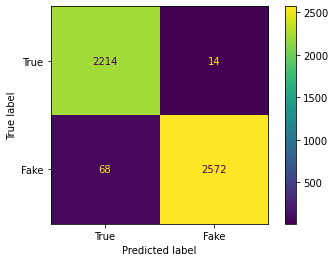

In [12]:
predictions_val = model.predict(X_val)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['True', 'Fake'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")

## Summary

Great, the baseline is really accruate, at this accuracy its more than effective.  It wasn't really the focus for the 
________________________________________________________________________________________________________________________

# Text Summarization

## Topic Modeling

From looking at the words and their frequencies to seeing which topics the words 

In [2]:
text = """Peter and Elizabeth took a taxi to attend the night party in the city. 
While in the party, Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury, 
the texttor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving.
"""

print(text)

text = text.replace(",", "")

print(text)

Peter and Elizabeth took a taxi to attend the night party in the city. 
While in the party, Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury, 
the texttor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving.

Peter and Elizabeth took a taxi to attend the night party in the city. 
While in the party Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury 
the texttor told Peter to stay besides her until she gets well. Therefore Peter stayed with her at the hospital for 3 days without leaving.



In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=1, min_df=0, max_features=5000)
# Apply the count vectorized method 
tf = tf_vectorizer.fit_transform([text])
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
# Visualise the 10 most common words
print(tf_feature_names)

['and', 'at', 'attend', 'besides', 'brain', 'city', 'collapsed', 'days', 'diagnosed', 'elizabeth', 'for', 'gets', 'her', 'hospital', 'in', 'injury', 'leaving', 'night', 'party', 'peter', 'rushed', 'she', 'since', 'stay', 'stayed', 'taxi', 'texttor', 'the', 'therefore', 'to', 'told', 'took', 'until', 'was', 'well', 'while', 'with', 'without']


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [91]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
 
CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')
#transform
Count_data = CountVec.fit_transform([text])
 
#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(cv_dataframe)

   attend  brain  city  collapsed  days  diagnosed  elizabeth  gets  hospital  \
0       1      1     1          1     1          1          2     1         2   

   injury  ...  night  party  peter  rushed  stay  stayed  taxi  texttor  \
0       1  ...      1      2      3       1     1       1     1        1   

   told  took  
0     1     1  

[1 rows x 21 columns]


In [5]:
import spacy
from spacy.lang.en import English
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn

parser = English()
spacy.load('en_core_web_sm')
en_stop = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

prepare_text_for_lda(text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['peter',
 'elizabeth',
 'attend',
 'night',
 'party',
 'party',
 'elizabeth',
 'collapse',
 'rush',
 'hospital',
 'since',
 'diagnose',
 'brain',
 'injury',
 'texttor',
 'peter',
 'besides',
 'therefore',
 'peter',
 'stay',
 'hospital',
 'without',
 'leaving']

In [19]:
from gensim import corpora

# Convert to list
data = text.split("delimiter")
print(data[:1])


#Tokenize the sentence into words
tokens = [word for word in text.split()]

dictionary = corpora.Dictionary([tokens])
corpus = [dictionary.doc2bow(tokens) for text in data]
# import pickle
# pickle.dump(corpus, open('corpus.pkl', 'wb'))
# dictionary.save('dictionary.gensim')

['Peter and Elizabeth took a taxi to attend the night party in the city. \nWhile in the party Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury \nthe texttor told Peter to stay besides her until she gets well. Therefore Peter stayed with her at the hospital for 3 days without leaving.\n']


In [92]:
from sklearn.decomposition import LatentDirichletAllocation

def print_topics(model, count_vectorizer, n_top_words):
    ''' Print the topics detected and the n_top_words that contains
    Input:
       - model: LDA model for the text
       - count_cectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    '''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
 
 # Apply the LDA method to discover the topics
lda_model = LatentDirichletAllocation(n_components=3, learning_method='online', max_iter=10, random_state=0).fit(tf)
# Show the topics and the 10 more relevant words in each topic
no_top_words = 5
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, tf_vectorizer, no_top_words)

Topics found via LDA:

Topic #0:
in and attend leaving for

Topic #1:
the peter to was hospital

Topic #2:
well hospital days while city


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### viewing topics


In [23]:
import gensim
import re

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = text.split("delimiter")
data_words = list(sent_to_words(data))
print(data_words[:1])

[['peter', 'and', 'elizabeth', 'took', 'taxi', 'to', 'attend', 'the', 'night', 'party', 'in', 'the', 'city', 'while', 'in', 'the', 'party', 'elizabeth', 'collapsed', 'and', 'was', 'rushed', 'to', 'the', 'hospital', 'since', 'she', 'was', 'diagnosed', 'with', 'brain', 'injury', 'the', 'texttor', 'told', 'peter', 'to', 'stay', 'besides', 'her', 'until', 'she', 'gets', 'well', 'therefore', 'peter', 'stayed', 'with', 'her', 'at', 'the', 'hospital', 'for', 'days', 'without', 'leaving']]


In [24]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy

stopwords = set(stopwords.words("english"))


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stopwords=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

print(data_ready)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


[['take', 'taxi', 'attend', 'collapse', 'rush', 'hospital', 'diagnose', 'brain', 'injury', 'texttor', 'tell', 'besides', 'get', 'well', 'therefore', 'stay', 'hospital', 'day', 'leave']]


In [25]:
import gensim.corpora as corpora



# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.096*"hospital" + 0.053*"take" + 0.053*"injury" + 0.053*"texttor" + 0.053*"brain" + 0.053*"collapse" + 0.053*"taxi" + 0.053*"diagnose" + 0.053*"besides" + 0.053*"well"'), (1, '0.056*"get" + 0.056*"leave" + 0.056*"attend" + 0.056*"therefore" + 0.056*"besides" + 0.056*"stay" + 0.056*"brain" + 0.056*"well" + 0.056*"tell" + 0.056*"day"'), (2, '0.056*"attend" + 0.056*"day" + 0.056*"tell" + 0.056*"stay" + 0.056*"get" + 0.056*"leave" + 0.056*"rush" + 0.056*"besides" + 0.056*"therefore" + 0.056*"well"'), (3, '0.056*"rush" + 0.056*"stay" + 0.056*"therefore" + 0.056*"get" + 0.056*"well" + 0.056*"taxi" + 0.056*"day" + 0.056*"attend" + 0.056*"diagnose" + 0.056*"tell"')]


In [79]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9623,"hospital, take, injury, texttor, brain, collap...","[take, taxi, attend, collapse, rush, hospital,..."


In [32]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE

print(corpus)
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=1, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


ValueError: perplexity must be less than n_samples

In [33]:
#  Possibly keep

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the Topic Clusters using seaborn
sns.set(rc= {'figure.figsize': (10,10)})
sns.scatterplot(tsne_lda[:,0], tsne_lda[:,1],hue=topic_num)
plt.show()

NameError: name 'tsne_lda' is not defined

## text summarization

In [34]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

text = nlp("""Peter and Elizabeth took a taxi to attend the night party in the city. 
the doctor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving.
""")


doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})


In [35]:
# Source for code: https://blog.floydhub.com/gentle-introduction-to-text-summarization-in-machine-learning/

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

article_content  = """A dish of living brain cells has learned to play the 1970s arcade game Pong.
About 800,000 cells linked to a computer gradually learned to sense the position of the game's electronic ball and control a virtual paddle, a team reports in the journal Neuron.
The novel achievement is part of an effort to understand how the brain learns, and how to make computers more intelligent.
"We've made huge strides with silicon computing, but they're still rigid and inflexible," says Brett Kagan, an author of the study and chief scientific officer at Cortical Labs in Melbourne, Australia. "That's something we don't see with biology."
For example, both computers and people can learn to make a cup of tea, Kagan says. But people are able to generalize what they've learned in a way a computer can't.
"You might have never been to someone else's house, but with a bit of rummaging and searching you can probably make a decent cup of tea as long as I've got the ingredients," he says. But even a very powerful computer would struggle to carry out that task in an unfamiliar environment.
So Cortical Labs has been trying to understand how living brain cells acquire this sort of intelligence. And Kagan says the Pong experiment was a way for the company to answer a key question about how a network of brain cells learns to change its behavior:
"If we allow these cells to know the outcome of their actions, will they actually be able to change in some sort of goal-directed way," Kagan says.
To find out, the scientists used a system they've developed called DishBrain.A layer of living neurons is grown on a special silicon chip at the bottom of a thumb-size dish filled with nutrients. The chip, which is linked to a computer, can both detect electrical signals produced by the neurons, and deliver electrical signals to them.
To test the learning ability of the cells, the computer generated a game of Pong, a two-dimensional version of table tennis that gained a cult following as one of the first and most basic video games.
Pong is played on a video screen. A black rectangle defines the table, and a white cursor represents each player's paddle, which can be moved up or down to intercept a white ball.
In the simplified version used in the experiment, there was a single paddle on the left side of the virtual table, and the ball would carom off the other sides until it evaded the paddle.
To allow the brain cells to play the game, the computer sent signals to them indicating where the bouncing ball was. At the same time, it began monitoring information coming from the cells in the form of electrical pulses.
"We took that information and we allowed it to influence this Pong game that they were playing," Kagan says. "So they could move the paddle around."
At first, the cells didn't understand the signals coming from the computer, or know what signals to send the other direction. They also had no reason to play the game.
So the scientists tried to motivate the cells using electrical stimulation: a nicely organized burst of electrical activity if they got it right. When they got it wrong, the result was a chaotic stream of white noise.
"If they hit the ball, we gave them something predictable," Kagan says. "When they missed it, they got something that was totally unpredictable."
The strategy was based on the Free Energy Principle, which states that brain cells want to be able to predict what's going on in their environment. So they would choose predictable stimulation over unpredictable stimulation.
The approach worked. Cells began to learn to generate patterns of electrical activity that would move the paddle in front of the ball, and gradually rallies got longer.
The brain cells never got that good at Pong. But interestingly, human brain cells seemed to achieve a slightly higher level of play than mouse brain cells, Kagan says.
And the level of play was remarkable, considering that each network contained fewer cells than the brain of a cockroach, Kagan says.
"If you could see a cockroach playing a game of Pong and it was able to hit the ball twice as often as it was missing it, you would be pretty impressed with that cockroach," he says.
The results hint at a future in which biology helps computers become more intelligent by changing the way that they learn, Kagan says.
But that future is probably still a long way off, says Steve M. Potter, an adjunct associate professor at Georgia Tech.
"The idea of a computer that has some living components is exciting and it's starting to become a reality," he says. "However, the kinds of learning that these things can accomplish is quite rudimentary right now."
"""

def _create_dictionary_table(text_string) -> dict:
       
    #removing stop words
    stop_words = set(stopwords.words("english"))
    
    words = word_tokenize(text_string)
    
    #reducing words to their root form
    stem = PorterStemmer()
    
    #creating dictionary for the word frequency table
    frequency_table = dict()
    for wd in words:
        wd = stem.stem(wd)
        if wd in stop_words:
            continue
        if wd in frequency_table:
            frequency_table[wd] += 1
        else:
            frequency_table[wd] = 1

    return frequency_table


def _calculate_sentence_scores(sentences, frequency_table) -> dict:   

    #algorithm for scoring a sentence by its words
    sentence_weight = dict()

    for sentence in sentences:
        sentence_wordcount = (len(word_tokenize(sentence)))
        sentence_wordcount_without_stop_words = 0
        for word_weight in frequency_table:
            if word_weight in sentence.lower():
                sentence_wordcount_without_stop_words += 1
                if sentence[:7] in sentence_weight:
                    sentence_weight[sentence[:7]] += frequency_table[word_weight]
                else:
                    sentence_weight[sentence[:7]] = frequency_table[word_weight]

        sentence_weight[sentence[:7]] = sentence_weight[sentence[:7]] / sentence_wordcount_without_stop_words

       

    return sentence_weight

def _calculate_average_score(sentence_weight) -> int:
   
    #calculating the average score for the sentences
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    #getting sentence average value from source text
    average_score = (sum_values / len(sentence_weight))

    return average_score

def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence[:7] in sentence_weight and sentence_weight[sentence[:7]] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

def _run_article_summary(article):
    
    #creating a dictionary for the word frequency table
    frequency_table = _create_dictionary_table(article)

    #tokenizing the sentences
    sentences = sent_tokenize(article)

    #algorithm for scoring a sentence by its words
    sentence_scores = _calculate_sentence_scores(sentences, frequency_table)

    #getting the threshold
    threshold = _calculate_average_score(sentence_scores)

    #producing the summary
    article_summary = _get_article_summary(sentences, sentence_scores, 1.1 * threshold)

    return article_summary

if __name__ == '__main__':
    summary_results = _run_article_summary(article_content)
    print(summary_results)

 The novel achievement is part of an effort to understand how the brain learns, and how to make computers more intelligent. For example, both computers and people can learn to make a cup of tea, Kagan says. Pong is played on a video screen. To allow the brain cells to play the game, the computer sent signals to them indicating where the bouncing ball was. At the same time, it began monitoring information coming from the cells in the form of electrical pulses. "We took that information and we allowed it to influence this Pong game that they were playing," Kagan says. "So they could move the paddle around." At first, the cells didn't understand the signals coming from the computer, or know what signals to send the other direction. They also had no reason to play the game. "If they hit the ball, we gave them something predictable," Kagan says. The approach worked. The brain cells never got that good at Pong. But interestingly, human brain cells seemed to achieve a slightly higher level of